<a href="https://colab.research.google.com/github/zy366lou/ECE196_WI21/blob/main/Gesture.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive/', force_remount = True)

Mounted at /content/drive/


In [2]:
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

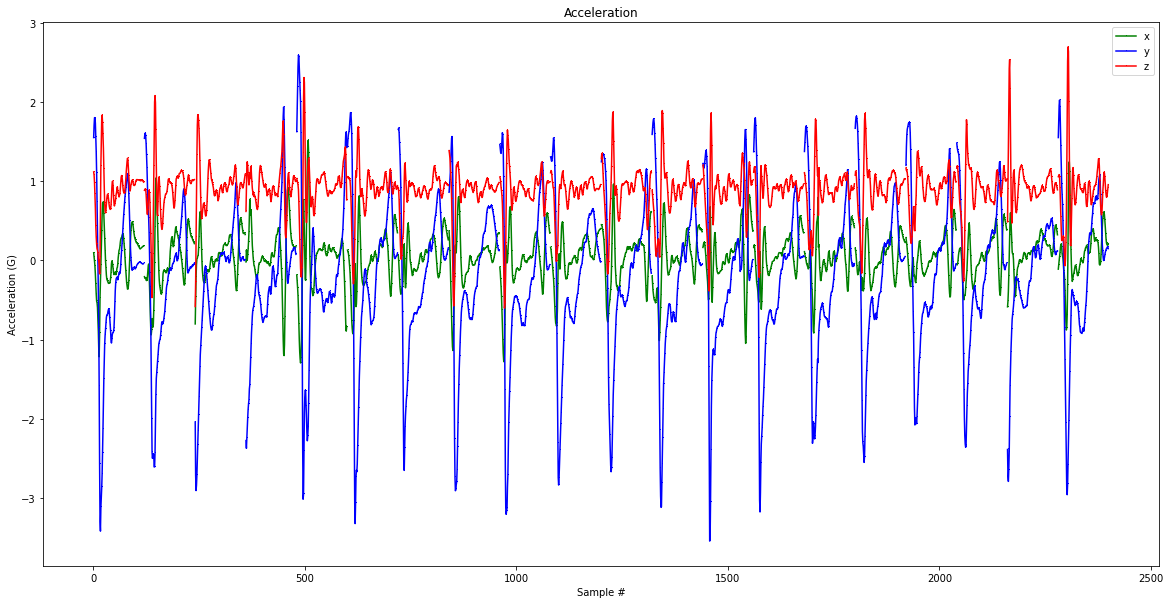

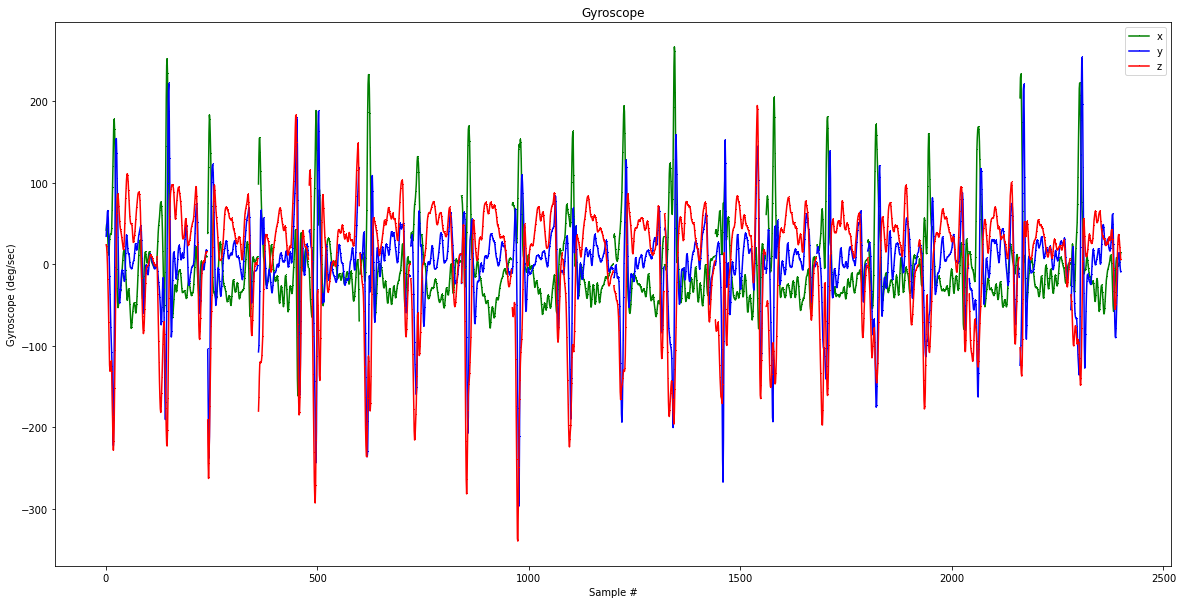

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

filename = "Punch.csv"

df = pd.read_csv("/content/drive/My Drive/OnBoardTensorFlow/" + filename)

index = range(1, len(df['aX']) + 1)

plt.rcParams["figure.figsize"] = (20,10)

plt.plot(index, df['aX'], 'g.', label='x', linestyle='solid', marker=',')
plt.plot(index, df['aY'], 'b.', label='y', linestyle='solid', marker=',')
plt.plot(index, df['aZ'], 'r.', label='z', linestyle='solid', marker=',')
plt.title("Acceleration")
plt.xlabel("Sample #")
plt.ylabel("Acceleration (G)")
plt.legend()
plt.show()

plt.plot(index, df['gX'], 'g.', label='x', linestyle='solid', marker=',')
plt.plot(index, df['gY'], 'b.', label='y', linestyle='solid', marker=',')
plt.plot(index, df['gZ'], 'r.', label='z', linestyle='solid', marker=',')
plt.title("Gyroscope")
plt.xlabel("Sample #")
plt.ylabel("Gyroscope (deg/sec)")
plt.legend()
plt.show()

In [4]:
GESTURES = ["Punch","Flex"]
SAMPLES_PER_GESTURE = 119
NUM_GESTURES = len(GESTURES)
ONE_HOT_GESTURES = np.eye(NUM_GESTURES) #create one-hot encoded matrix
NUM_SENSOR = 6 

inputs = [] # create empty lists 
outputs = [] 

#scaler = MinMaxScaler()
for g_idx in range(NUM_GESTURES):
  g = GESTURES[g_idx]
  output = ONE_HOT_GESTURES[g_idx]
  df = pd.read_csv("/content/drive/My Drive/OnBoardTensorFlow/" + g + ".csv")
  # Data Normalization for each column: ax, ay, az, gx, gy, gz; meanwhile, remove last column (which is empty)
# Did not use MinMaxScaler here so that the arduino board can perform real time normalization
#  df_scaled = scaler.fit_transform(df.iloc[:,:-1])  
#  df_scaled_DF = pd.DataFrame(df_scaled)  #convert df_scaled to Dataframe
#  df_scaled_DF = df_scaled_DF.dropna()    #drop na from the dataframe
  df = df.iloc[:,:-1].dropna()
  df_scale = df
  df_scale.iloc[:,0:3] = (df.iloc[:,0:3]+4)/8 #last column does not count!!!
  df_scale.iloc[:,3:6] = (df.iloc[:,3:6]+450)/900
  df_scaled_DF = df_scale
  num_recordings = int(df_scaled_DF.shape[0] / SAMPLES_PER_GESTURE)

  for i in range(num_recordings):
    # select sensor data in each gesture
    sensorData = df_scaled_DF.iloc[i*SAMPLES_PER_GESTURE:(i+1)*SAMPLES_PER_GESTURE,:]
    sensorData_np = np.array(sensorData) # convert to numpy array
    sensorData_np = np.reshape(sensorData_np,SAMPLES_PER_GESTURE*NUM_SENSOR)
    inputs.append(sensorData_np)
    outputs.append(output)


In [5]:
df_scale.iloc[:,3].max()

0.7846277777777777

In [6]:
(df.iloc[:,3:6]+5)/10

,gX,gY,gZ
0,0.533093,0.553635,0.553540
1,0.531310,0.553391,0.553906
2,0.529465,0.553540,0.554489
3,0.527220,0.554239,0.555371
4,0.525104,0.555459,0.556578
...,...,...,...
2394,0.551600,0.549356,0.548644
2395,0.551458,0.549736,0.548874
2396,0.551424,0.550176,0.549118
2397,0.551221,0.550556,0.549403


In [7]:
data = np.array(inputs)
label = np.array(outputs)

In [8]:
X_train, X_test, y_train, y_test = train_test_split(data, label, test_size=0.2, random_state=42)

In [9]:
# build the model and train it
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(100, activation='relu')) # relu is used for performance
#model.add(tf.keras.layers.Dropout(0.1))
model.add(tf.keras.layers.Dense(50, activation='relu')) # relu is used for performance
#model.add(tf.keras.layers.Dropout(0.1))
model.add(tf.keras.layers.Dense(15, activation='relu'))
model.add(tf.keras.layers.Dense(NUM_GESTURES, activation='softmax')) # softmax is used, because we only expect one gesture to occur per input
model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
history = model.fit(X_train, y_train,validation_data=(X_test, y_test), epochs=600, batch_size=1)


Epoch 1/600
32/32 [==============================] - 1s 8ms/step - loss: 0.2811 - mae: 0.5080 - val_loss: 0.2481 - val_mae: 0.4981
Epoch 2/600
32/32 [==============================] - 0s 3ms/step - loss: 0.2537 - mae: 0.5035 - val_loss: 0.2477 - val_mae: 0.4977
Epoch 3/600
32/32 [==============================] - 0s 3ms/step - loss: 0.2499 - mae: 0.4996 - val_loss: 0.2400 - val_mae: 0.4897
Epoch 4/600
32/32 [==============================] - 0s 3ms/step - loss: 0.2447 - mae: 0.4945 - val_loss: 0.2468 - val_mae: 0.4959
Epoch 5/600
32/32 [==============================] - 0s 3ms/step - loss: 0.2318 - mae: 0.4806 - val_loss: 0.2111 - val_mae: 0.4592
Epoch 6/600
32/32 [==============================] - 0s 4ms/step - loss: 0.2076 - mae: 0.4541 - val_loss: 0.1784 - val_mae: 0.4219
Epoch 7/600
32/32 [==============================] - 0s 3ms/step - loss: 0.1687 - mae: 0.4061 - val_loss: 0.1252 - val_mae: 0.3534
Epoch 8/600
32/32 [==============================] - 0s 3ms/step - loss: 0.1131 - m

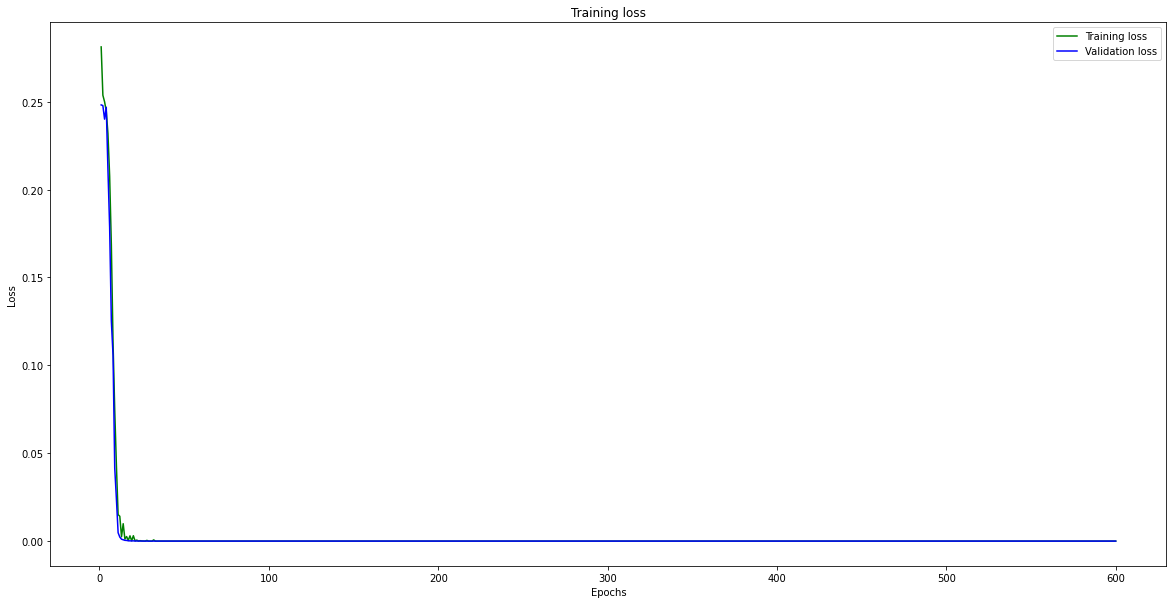

[20.0, 10.0]


In [10]:
# increase the size of the graphs. The default size is (6,4).
plt.rcParams["figure.figsize"] = (20,10)

# graph the loss, the model above is configure to use "mean squared error" as the loss function
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss,'g', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

print(plt.rcParams["figure.figsize"])

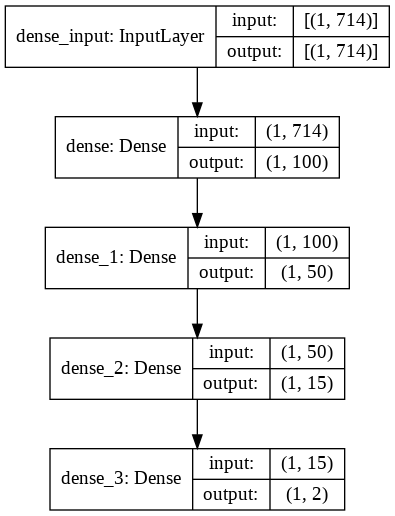

In [11]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [12]:
# use the model to predict the test inputs
predictions = model.predict(X_test)

# print the predictions and the expected ouputs
print("predictions =\n", np.round(predictions, decimals=3))
print("actual =\n", y_test)


predictions =
 [[1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]]
actual =
 [[1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]]


In [13]:
# Convert the model to the TensorFlow Lite format without quantization
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model to disk
open("gesture_model.tflite", "wb").write(tflite_model)
  
import os
basic_model_size = os.path.getsize("gesture_model.tflite")
print("Model is %d bytes" % basic_model_size)
  
  

INFO:tensorflow:Assets written to: /tmp/tmp8mfxrgax/assets
Model is 311444 bytes


In [14]:
!apt-get -qq install xxd

In [15]:
!echo "const unsigned char model[] = {" > /content/model.h
!cat gesture_model.tflite | xxd -i      >> /content/model.h
!echo "};"                              >> /content/model.h

import os
model_h_size = os.path.getsize("model.h")
print(f"Header file, model.h, is {model_h_size:,} bytes.")
print("\nOpen the side panel (refresh if needed). Double click model.h to download the file.")

Header file, model.h, is 1,920,606 bytes.

Open the side panel (refresh if needed). Double click model.h to download the file.
